In [1]:
from Functions import *


In [2]:
''' loop parameters '''
NN = 300
delta_list = 1e-6*np.linspace(-1, 1, NN)
crystal_list = [1,2,3,4]
#alphaAsym = np.deg2rad(27.98)

if_loop = 1			# to loop or not to loop


In [3]:
''' Beam parameters '''
N = 2048			# number of sampling points
E0 = 17795			# photon energy [eV]
tau = 100			# pulse duration [fs]
window = 4000		# total simulation time window [fs]

''' OE parameters '''
hkl = [6,6,0]
#hkl = [4,4,0]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 630
}


In [4]:
''' Define beamline '''
try: alphaAsym
except:
    crystal_temp = optics.Crystal('crystal', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                                  alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    alphaAsym = crystal_temp.alpha - np.deg2rad(5)      # calculate miscut angle (5 degree grazing incidence)

    if alphaAsym <= 0:
        print('\n***\n***\n*** Bragg angle smaller than grazing angle')

f1 = 9.773134939594566
f2 = 10.

devices = define_devices(f1,f2,slit_width = 500e-6, hkl = hkl,
                         alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)


b 1.00
b 1.00
b 10.01
crystal 2 incidence angle: 60.95 degrees
crystal 2 exit angle: 5.01 degrees
b 1.00
b 0.10


In [5]:
''' propagate '''
blockPrint()
mono_beamline = beamline.Beamline(devices)

tstart = time.time()
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)

pulse.propagate(beamline=mono_beamline, screen_names=['im0','im2'])
tfin = time.time()


C:\Users\nanw0\Anaconda3\envs\lcls\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [6]:
''' IO '''
path = '../{} eV/'.format(E0)
make_dir(path)

fig_path = path+'/delta_scan/'
make_dir(fig_path)

hkl_ = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'delta_tolerance_{}_{}keV'.format(
	hkl_, round(beam_params['photonEnergy']/1000.,4))

blockPrint()


In [7]:
%%capture capt
tstart = time.time()
''' loop '''
if if_loop == 1:
    if os.path.exists(fig_path+fname+'.h5'):
        os.remove(fig_path+fname+'.h5')
    for crystal in crystal_list:
        duration = np.zeros(NN)
        tilt = np.zeros(NN)
        bw = np.zeros(NN)
        throughput = np.zeros(NN)
        cent_E = np.zeros(NN)

        for i, delta in enumerate(delta_list):
            devices = define_devices(f1,f2,slit_width = 100e-6, hkl = hkl,
                                 alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)
            change_delta(devices, delta, crystal)
            mono_beamline = beamline.Beamline(devices)
            beam_params['photonEnergy'] = E0
            pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
            pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
            centroid, duration[i] = pulse.pulse_duration('im2')
            tilt[i] = pulse.pulsefront_tilt('im2')

        for i, delta in enumerate(delta_list):
            devices = define_devices(f1,f2,slit_width = 7e-6, hkl = hkl,
                                 alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)
            change_delta(devices, delta, crystal)
            mono_beamline = beamline.Beamline(devices)
            beam_params['photonEnergy'] = E0
            pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
            pulse.propagate(beamline=mono_beamline, screen_names=['im0', 'im2'])
            bw[i] = pulse.pulse_bandwidth('im2')
            throughput[i] = pulse.throughput('im0','im2')
            cent_E[i] = pulse.central_energy('im2')

        with h5py.File(fig_path+fname+'.h5','a') as f:
            grp = f.create_group('crystal{}'.format(crystal))
            grp.create_dataset('delta', data=delta_list)
            grp.create_dataset('duration', data=duration)
            grp.create_dataset('tilt', data=tilt)
            grp.create_dataset('bandwidth', data=bw)
            grp.create_dataset('throughput', data=throughput)
            grp.create_dataset('central_energy', data=cent_E)
tfin = time.time()

In [8]:
# total simulation time (estimated)
(300/NN) * (tfin - tstart) * (4/len(crystal_list))/3600

5.41655890736315

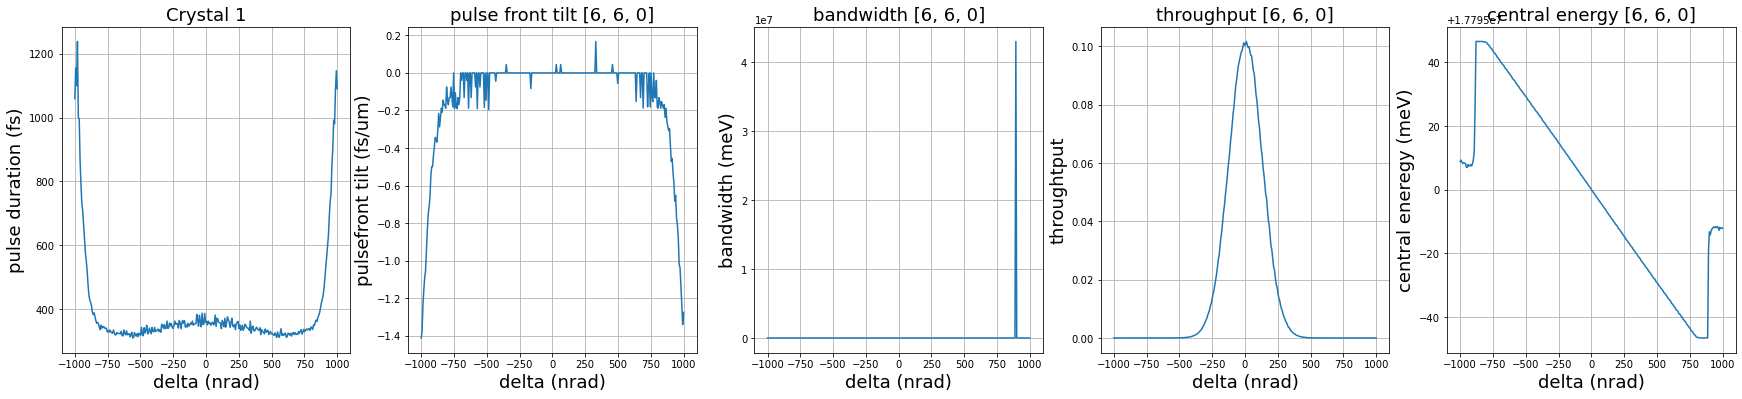

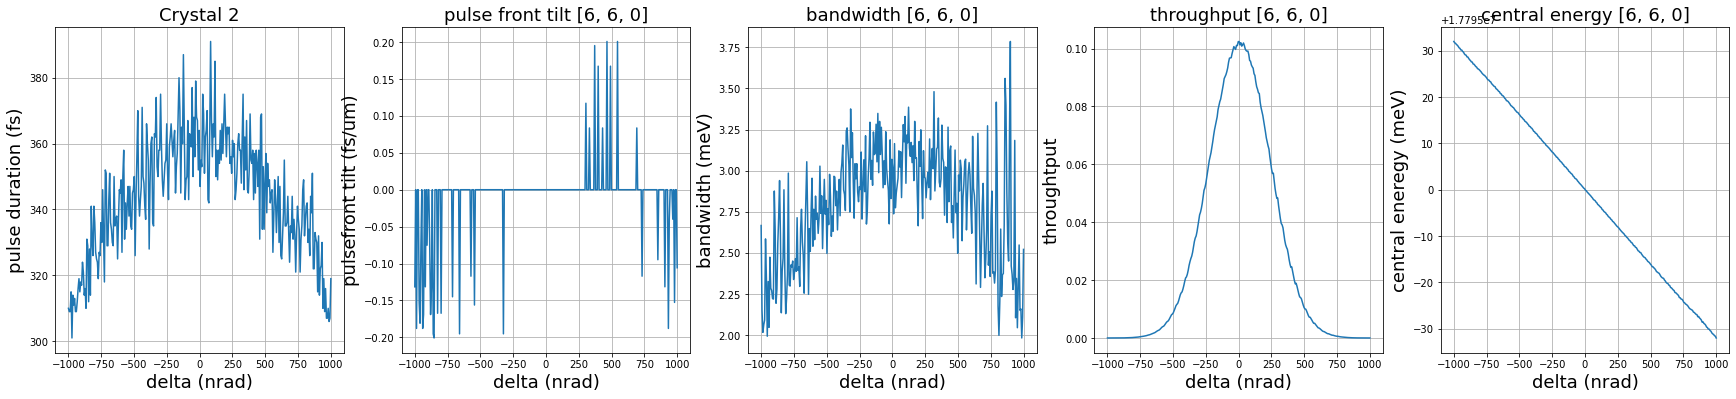

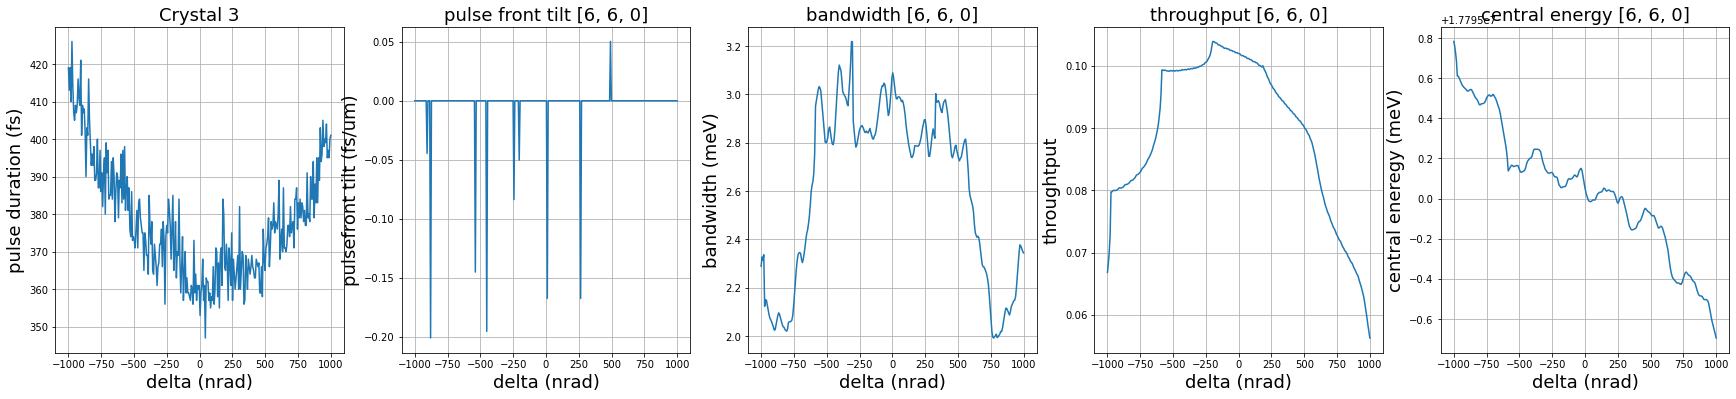

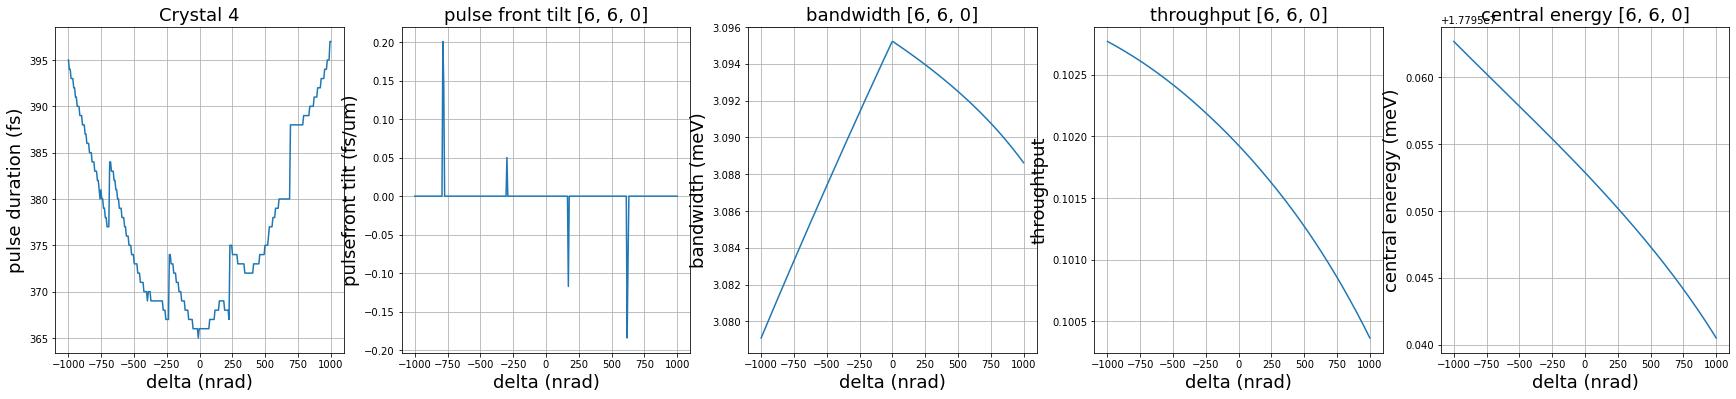

In [9]:
''' plot '''
for crystal in crystal_list:
    with h5py.File(fig_path+fname+'.h5', 'r') as f:
        grpname = 'crystal{}'.format(crystal)
        delta_list = f[grpname+'/delta'][:]
        duration = f[grpname+'/duration'][:]
        tilt = f[grpname+'/tilt'][:]
        bw = f[grpname+'/bandwidth'][:]
        throughput = f[grpname+'/throughput'][:]
        cent_E = f[grpname+'/central_energy'][:]
    
    # plots
    xx = delta_list * 1e9
    xlabel = 'delta (nrad)'

    # pulse duration
    plt.figure(figsize=(30,6))
    plt.subplot(1,5,1)
    plt.plot(xx, np.abs(duration))
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('pulse duration (fs)',fontsize=(18))

    plt.grid()
    plt.title('Crystal {}'.format(crystal),fontsize=(18))

    # pulsefront tilt
    plt.subplot(1,5,2)
    plt.plot(xx, tilt)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('pulsefront tilt (fs/um)',fontsize=(18))

    plt.grid()
    plt.title('pulse front tilt {}'.format(hkl),fontsize=(18))
    # bandwidth
    plt.subplot(1,5,3)
    plt.plot(xx, 1e3*bw)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('bandwidth (meV)',fontsize=(18))

    plt.grid()
    plt.title('bandwidth {}'.format(hkl),fontsize=(18))

    # throughput
    plt.subplot(1,5,4)
    plt.plot(xx, throughput)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('throughtput',fontsize=(18))

    plt.grid()
    plt.title('throughput {}'.format(hkl),fontsize=(18))

    # central energy
    plt.subplot(1,5,5)
    plt.plot(xx, 1e3*cent_E)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('central eneregy (meV)',fontsize=(18))

    plt.grid()
    plt.title('central energy {}'.format(hkl),fontsize=(18))

    plt.savefig(fig_path+'crystal{}_'.format(crystal)+fname+'.png')